# Challenge

For this challenge, you will be predicting a full year worth of sales for 4 items from two competing stores located in six different countries. This dataset is completely fictional, but contains many effects you see in real-world data, e.g., weekend and holiday effect, seasonality, etc. **You are given the challenging task of predicting book sales during the year 2021.**

Submissions are evaluated on [SMAPE](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error) between forecasts and actual values. We define SMAPE = 0 when the actual and predicted values are both 0.

In [24]:
import os
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Get Data

In [3]:
TEST_CSV = 'test.csv'  # no data snooping!
TRAIN_CSV = 'train.csv'
train_df = pd.read_csv(TRAIN_CSV)
train_df

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240
...,...,...,...,...,...,...
70123,70123,2020-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,614
70124,70124,2020-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,215
70125,70125,2020-12-31,Spain,KaggleRama,Kaggle Getting Started,158
70126,70126,2020-12-31,Spain,KaggleRama,Kaggle Recipe Book,135


# Explore

Study each attribute and it's characteristics!

In [4]:
# no missing data points
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    70128 non-null  int64 
 1   date      70128 non-null  object
 2   country   70128 non-null  object
 3   store     70128 non-null  object
 4   product   70128 non-null  object
 5   num_sold  70128 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.2+ MB


In [10]:
# convert columns to correct data types: int, datetime, string, string, string, int
mod_train_df = train_df.convert_dtypes()
mod_train_df['date'] = pd.to_datetime(mod_train_df['date'], infer_datetime_format=True)
mod_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   row_id    70128 non-null  Int64         
 1   date      70128 non-null  datetime64[ns]
 2   country   70128 non-null  string        
 3   store     70128 non-null  string        
 4   product   70128 non-null  string        
 5   num_sold  70128 non-null  Int64         
dtypes: Int64(2), datetime64[ns](1), string(3)
memory usage: 3.3 MB


## row_id

This is just uuid for each book sale row entry. Only needed for prediction submission; ignore for EDA and model building

## date

Sales entries has entries from each day starting from 2017-01-01 to 2020-12-31, inclusive.

In [13]:
mod_train_df.date.describe()

/var/folders/j4/dw0fc8zx6x7_mf87qvt4py1r0000gq/T/ipykernel_7306/2482076397.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  mod_train_df.date.describe()


count                   70128
unique                   1461
top       2017-01-01 00:00:00
freq                       48
first     2017-01-01 00:00:00
last      2020-12-31 00:00:00
Name: date, dtype: object

In [17]:
# there are 1461 unique datetime values, confirm this includes all dates
# within the first and last datetime
datetime(2017, 1, 1) + timedelta(days=1460)

datetime.datetime(2020, 12, 31, 0, 0)

2017-01-01 has 48 entries, is seems that is the same for each date entry. Which makes sense since challenges notes that there are "4 items from two competing stores located in six different countries" -> 4 x 2 x 6 = 48. We a given the sales from 2017 to end of 2020 to be used to predict sales for 2021.

So we should expect to see four different book products, two stores, across six countries.

In [20]:
48 * 1461, mod_train_df.date.value_counts()

(70128,
 2017-01-01    48
 2019-09-10    48
 2019-09-08    48
 2019-09-07    48
 2019-09-06    48
               ..
 2018-05-01    48
 2018-04-30    48
 2018-04-29    48
 2018-04-28    48
 2020-12-31    48
 Name: date, Length: 1461, dtype: int64)

### Total Sales Over Time

In [27]:
mod_train_df['year'] = mod_train_df.date.dt.year
mod_train_df['month'] = mod_train_df.date.dt.month

In [37]:
monthly_tot_df = mod_train_df.groupby(['year', 'month']).agg('sum')['num_sold']
monthly_tot_df = monthly_tot_df.reset_index()
monthly_tot_df

,year,month,num_sold
0,2017,1,281848
1,2017,2,236138
2,2017,3,258310
3,2017,4,260187
4,2017,5,263435
5,2017,6,245111
6,2017,7,252849
7,2017,8,251868
8,2017,9,240947
9,2017,10,253300


Sales per month analysis:
- with the exception of 2020, sales seem to increase cyclically quarterly, 2 - 5, 6 - 9, 10 - 1. With the largest spikes at the end of the year in December and January.
- in 2020 we see drastic increase compared to the others with major drop in sales in April but quick resurgence the subsequent month. This seems to map to when many folks were sent home to work remotely due to covid and most of the country shutdown for the pandemic.
    - this confirmed when looking at total annual sales, we see steady increase from 2017 to 2019 and then substantial jump in 2022.

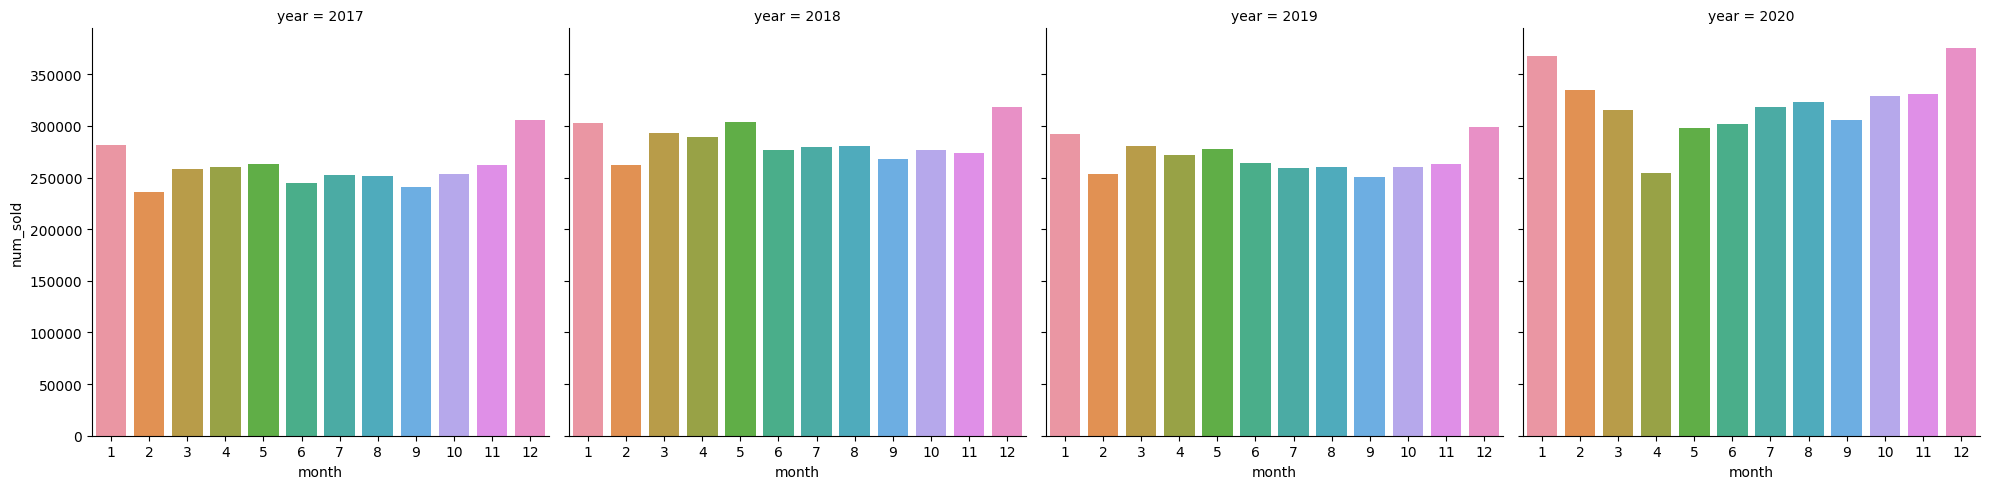

In [41]:
sns.catplot(x='month', y='num_sold', col='year', kind='bar', data=monthly_tot_df)

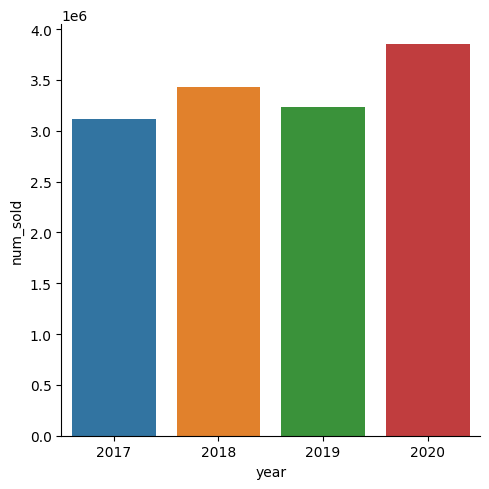

In [61]:
sns.catplot(
    x='year', y='num_sold',kind='bar',
    data=mod_train_df.groupby(['year']).agg('sum')['num_sold'].reset_index()
)

## country

As expected we have 6 unique countries: Belgium, France, Germany, Italy, Poland, and Spain.

In [22]:
mod_train_df.country.describe()

count       70128
unique          6
top       Belgium
freq        11688
Name: country, dtype: object

In [23]:
mod_train_df.country.unique()

<StringArray>
['Belgium', 'France', 'Germany', 'Italy', 'Poland', 'Spain']
Length: 6, dtype: string

In [48]:
country_df = mod_train_df.groupby(['year', 'month', 'country']).agg('sum')['num_sold']
country_df = country_df.reset_index()
country_df

,year,month,country,num_sold
0,2017,1,Belgium,60995
1,2017,1,France,53673
2,2017,1,Germany,62180
3,2017,1,Italy,45419
4,2017,1,Poland,19618
...,...,...,...,...
283,2020,12,France,61556
284,2020,12,Germany,62316
285,2020,12,Italy,64007
286,2020,12,Poland,62709


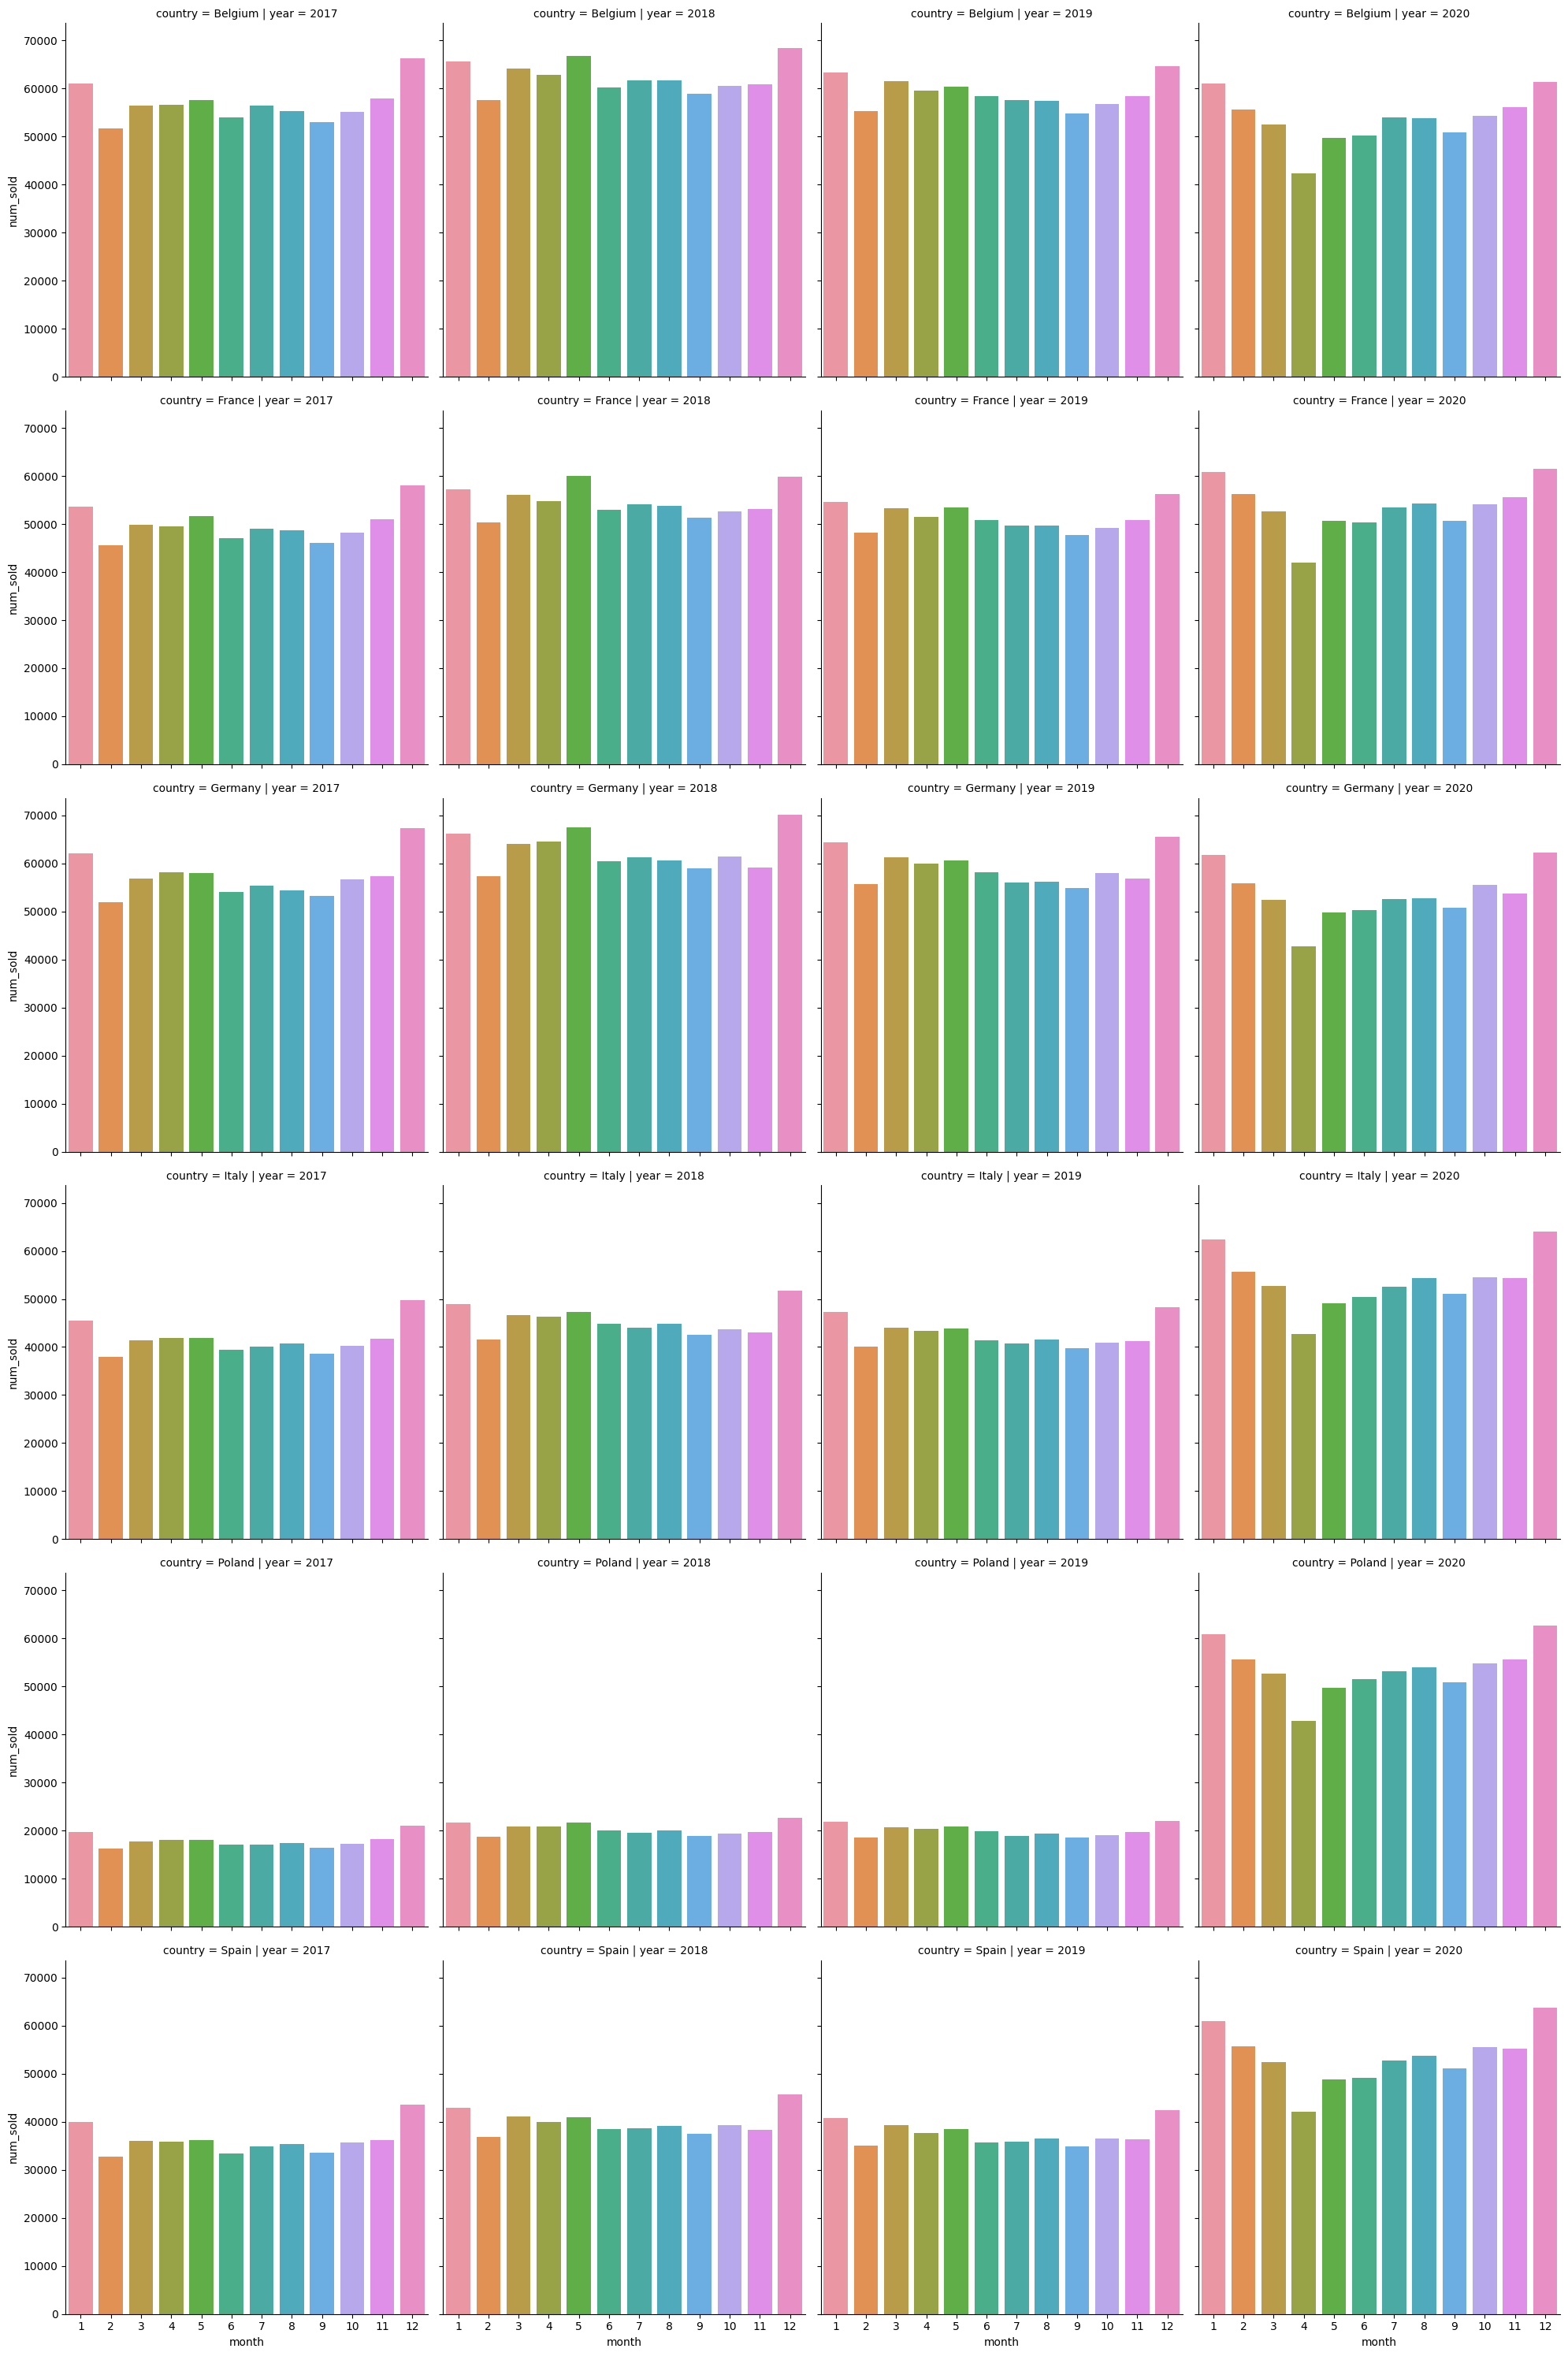

In [51]:
sns.catplot(
    x='month', y='num_sold',
    col='year', row='country',
    kind='bar', data=country_df
)

- all countries:
    - see substantial decrease in sales 04/2020 and then resurgence subsequent months
    - similar patterns for quarterly cycles in sales increases with highst peak in December
- Italy, Poland, and Spain see major increases (0.5x, 0.5x, & 3x respetively) in sales in 2020, compared to the other countries that only saw slight increases in 2020.
- all countries have the about the same annual sale for 2010

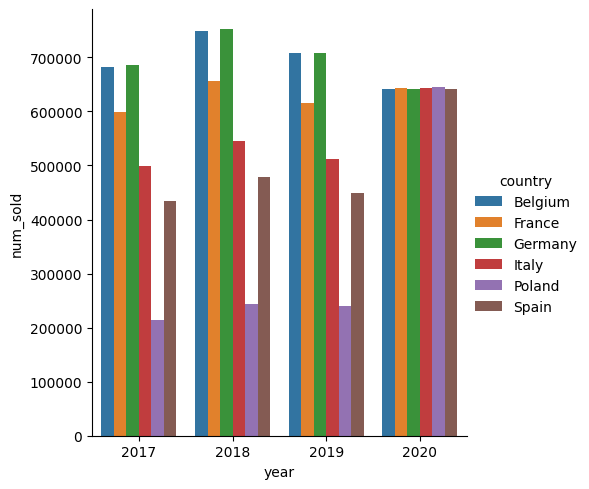

In [60]:
sns.catplot(
    x='year', y='num_sold', hue='country',
    kind='bar', data=mod_train_df.groupby(['year', 'country']).agg('sum')['num_sold'].reset_index()
)

## store

As expected there are only stores: KaggleMart and KaggleRama.

In [52]:
mod_train_df.store.describe()

count          70128
unique             2
top       KaggleMart
freq           35064
Name: store, dtype: object

In [53]:
mod_train_df.store.unique()

<StringArray>
['KaggleMart', 'KaggleRama']
Length: 2, dtype: string

In [55]:
store_tot_df = mod_train_df.groupby(['year', 'month', 'store']).agg('sum')['num_sold']
store_tot_df = store_tot_df.reset_index()
store_tot_df

,year,month,store,num_sold
0,2017,1,KaggleMart,209188
1,2017,1,KaggleRama,72660
2,2017,2,KaggleMart,175275
3,2017,2,KaggleRama,60863
4,2017,3,KaggleMart,191832
...,...,...,...,...
91,2020,10,KaggleRama,84966
92,2020,11,KaggleMart,245414
93,2020,11,KaggleRama,85198
94,2020,12,KaggleMart,279030


- again, major drop in sales in 04/2020 for both stores
- KaggleMart has ~4x more sales than KaggleRama each month
- while both see increased sales in 2020, the increase more substantial for KaggleMart

Notes:
- should look at the relationship between stores and countries with respect to sales. Wonder if KaggleRama predominantly only sells in specific countries while KaggleMart sales across all countries.

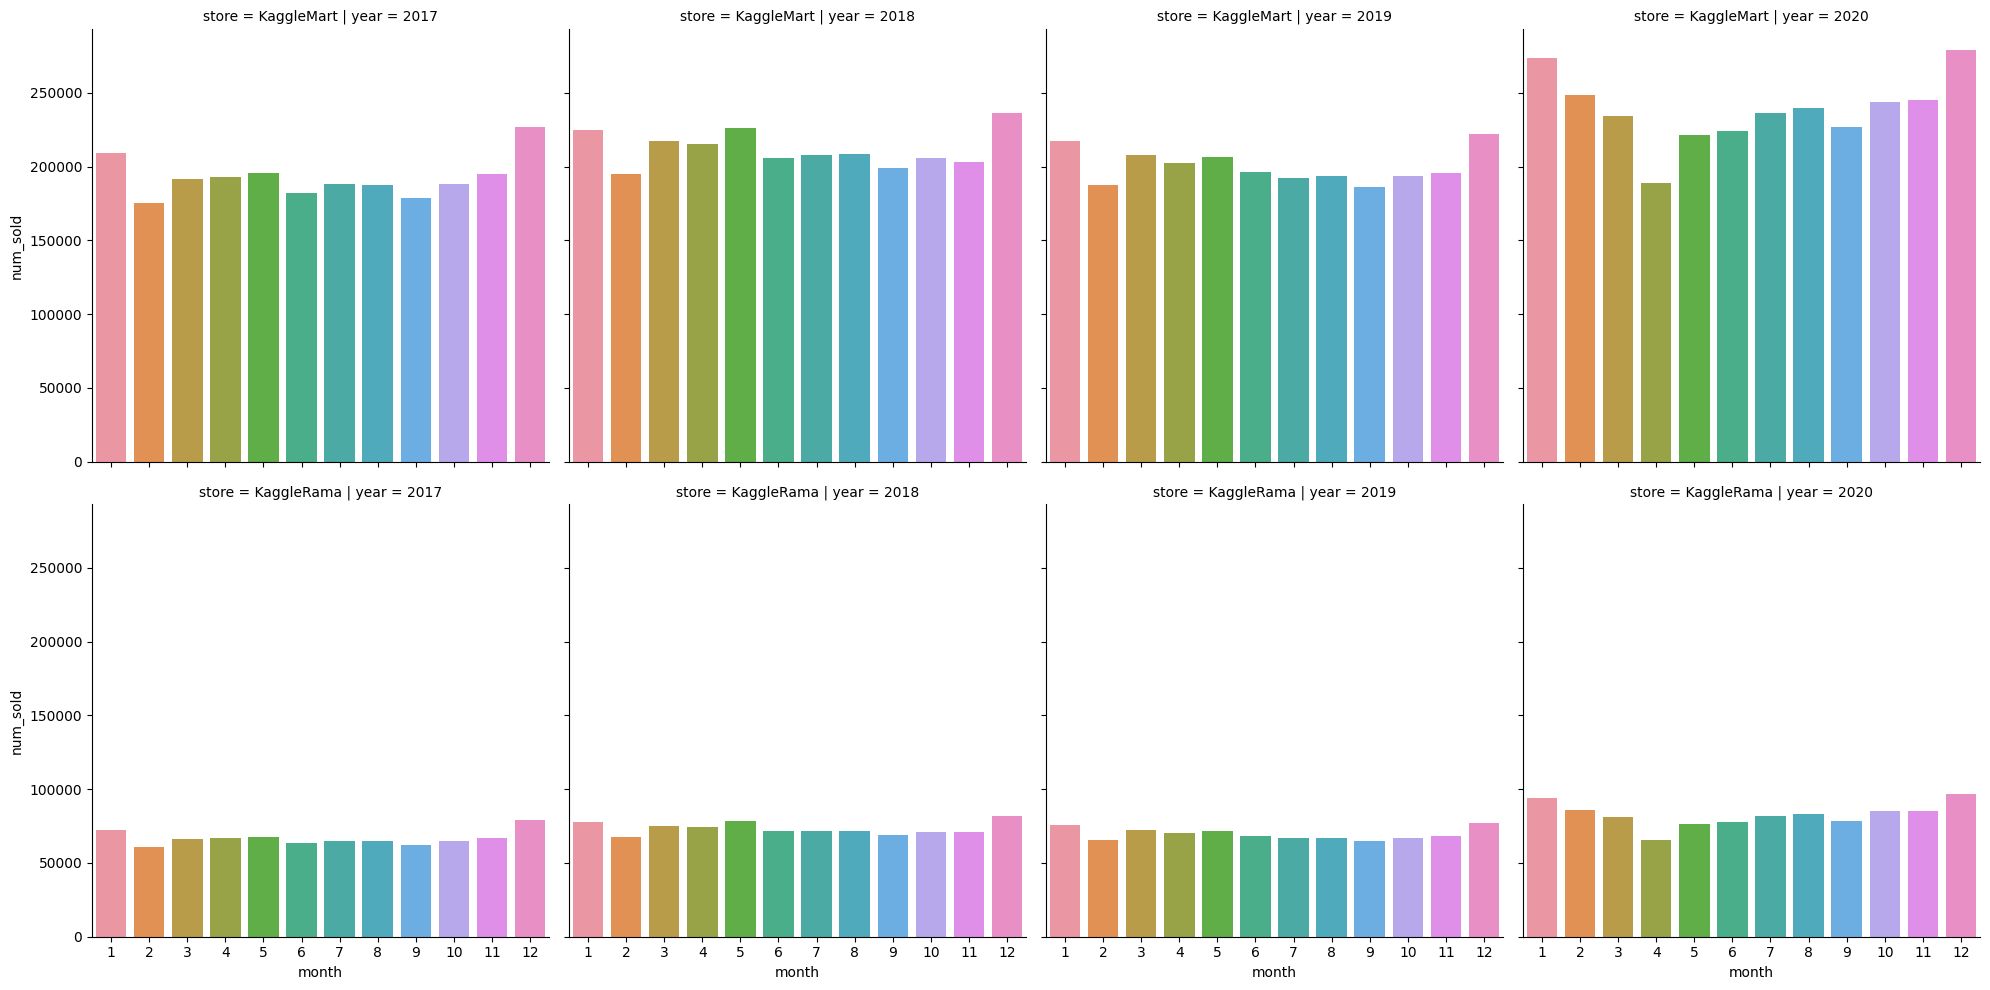

In [57]:
sns.catplot(
    x='month', y='num_sold',
    col='year', row='store',
    kind='bar', data=store_tot_df
)

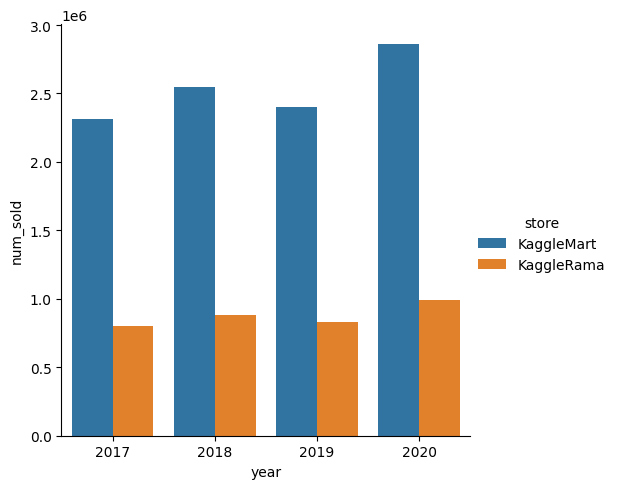

In [62]:
sns.catplot(
    x='year', y='num_sold', hue='store',
    kind='bar', data=mod_train_df.groupby(['year', 'store']).agg('sum')['num_sold'].reset_index()
)

## product

As expected, there are 4 books being sold.

In [67]:
mod_train_df['product'].describe()

count                          70128
unique                             4
top       Kaggle Advanced Techniques
freq                           17532
Name: product, dtype: object

In [69]:
 mod_train_df['product'].unique()

<StringArray>
[      'Kaggle Advanced Techniques',           'Kaggle Getting Started',
               'Kaggle Recipe Book', 'Kaggle for Kids: One Smart Goose']
Length: 4, dtype: string

In [70]:
product_tot_df = mod_train_df.groupby(['year', 'month', 'product']).agg('sum')['num_sold']
product_tot_df = product_tot_df.reset_index()
product_tot_df

,year,month,product,num_sold
0,2017,1,Kaggle Advanced Techniques,83101
1,2017,1,Kaggle Getting Started,61150
2,2017,1,Kaggle Recipe Book,52736
3,2017,1,Kaggle for Kids: One Smart Goose,84861
4,2017,2,Kaggle Advanced Techniques,76480
...,...,...,...,...
187,2020,11,Kaggle for Kids: One Smart Goose,103345
188,2020,12,Kaggle Advanced Techniques,101081
189,2020,12,Kaggle Getting Started,87879
190,2020,12,Kaggle Recipe Book,71543


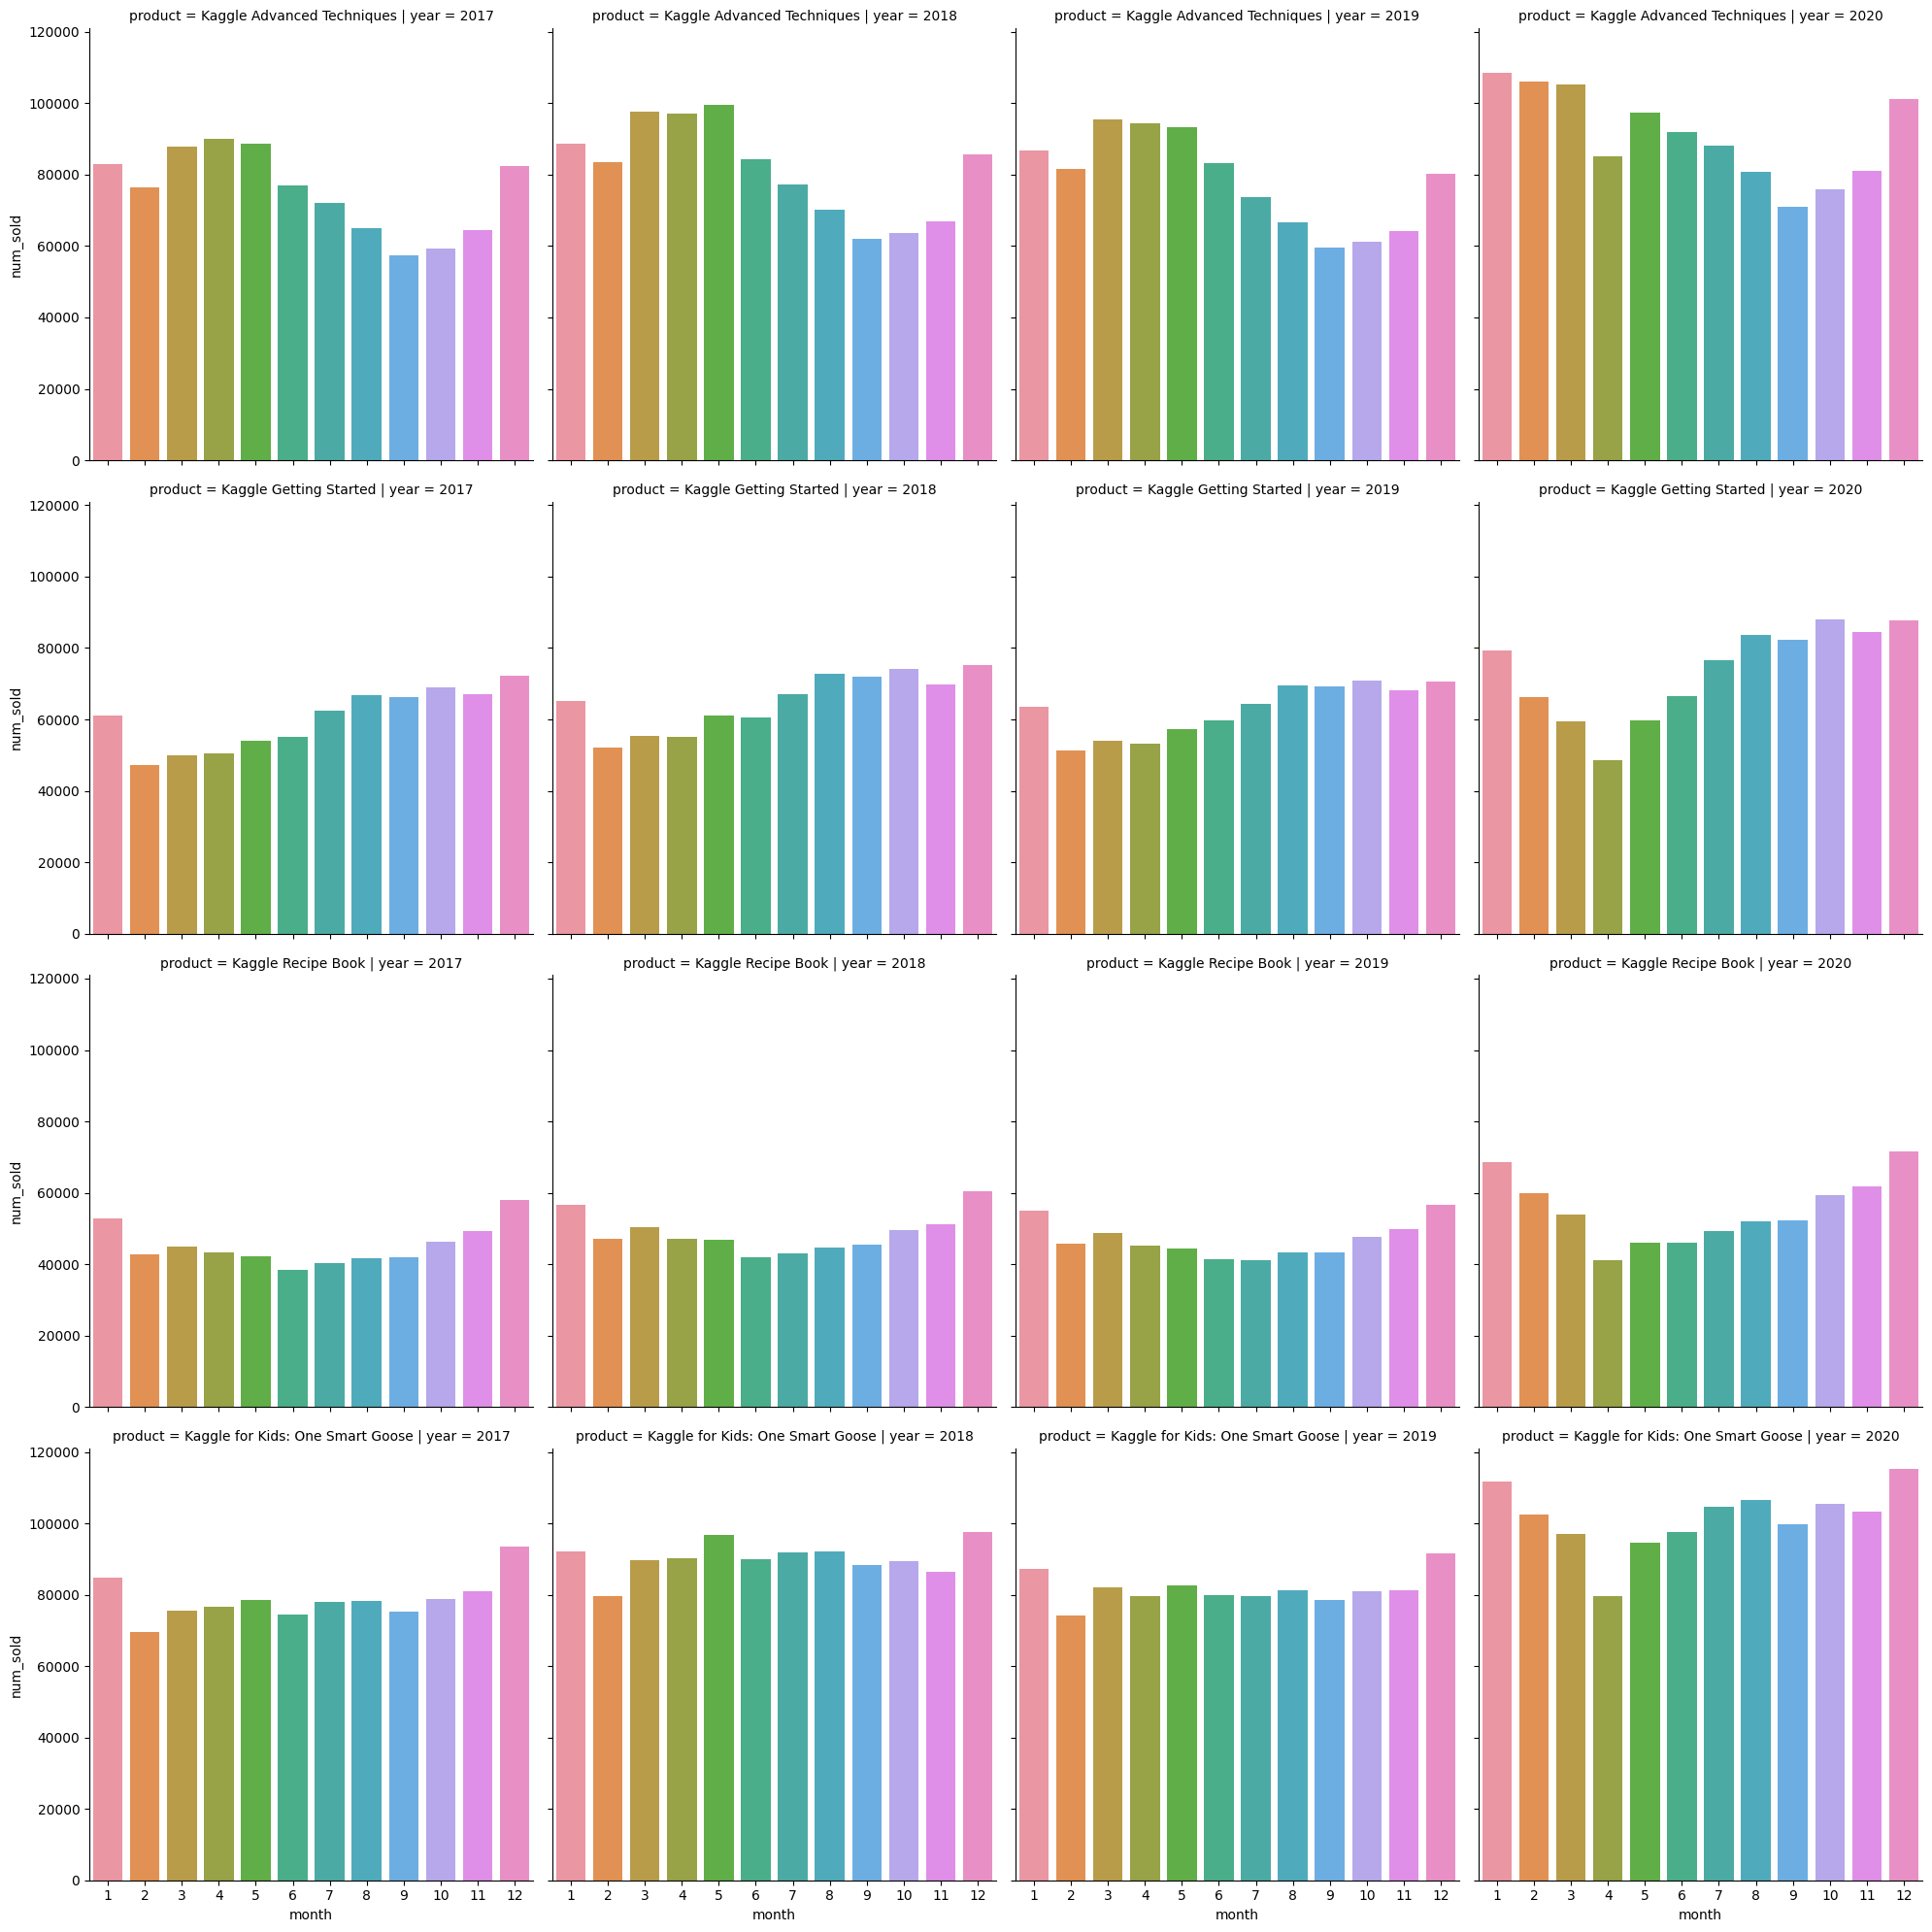

In [71]:
sns.catplot(
    x='month', y='num_sold',
    col='year', row='product',
    kind='bar', data=product_tot_df
)

- Kaggle Advanced Techniques is has cyclical sales pattern, with increasing sales starting in first five months and then downtun in sales followed by an uptick going into the end of the month.
    - in 2020, there's a sharp drop in sales in April with quick resurgence the following month and return to cylical sales pattern but less pronounced.
- Kaggle Getting Started also has cyclical sales pattern, with uptick in sales beginning in February plataueing at at the end of the year.
    - in 2020, the share drop in sales in April shifts the start of the gradual uptick in sales that usually begins in February but now starts in May
- Kaggle Recipe Book has relatively uniform sales throughout the year except for the months of December - January where there's considerable uptick in sales. There's slight decrease in sales in the middle of year but not by much.
    - the sharp drop in sales in 4/2020 leads to gradual increase each month with much higher sales in December
- Kaggle for Kids has relatively uniform sales throughout the year except for the months of December - January where there's considerable uptick in sales.
    - the sharp drop in sales in 4/2020 is followed by quick rebounce the following month and gradual increas followed by decrease until peak sales in December.

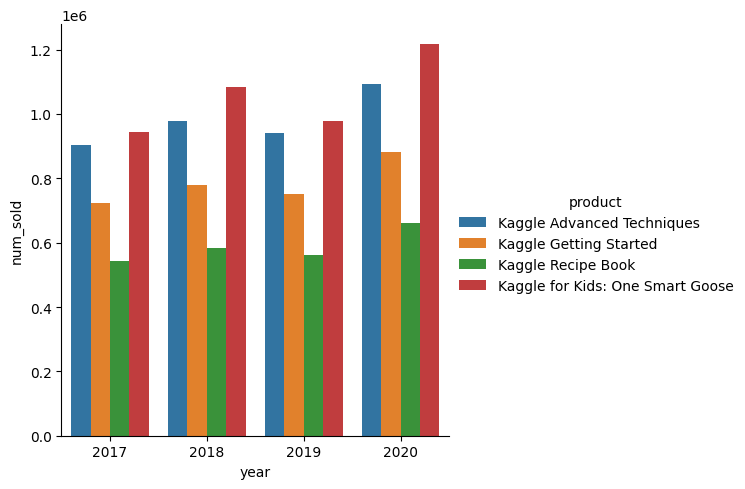

In [72]:
sns.catplot(
    x='year', y='num_sold', hue='product',
    kind='bar', data=mod_train_df.groupby(['year', 'product']).agg('sum')['num_sold'].reset_index()
)

## num_sold

Target attribute.

Books sales are bimodel, with

In [73]:
mod_train_df.num_sold.describe()

count    70128.000000
mean       194.296986
std        126.893874
min         19.000000
25%         95.000000
50%        148.000000
75%        283.000000
max        986.000000
Name: num_sold, dtype: float64

<AxesSubplot:>

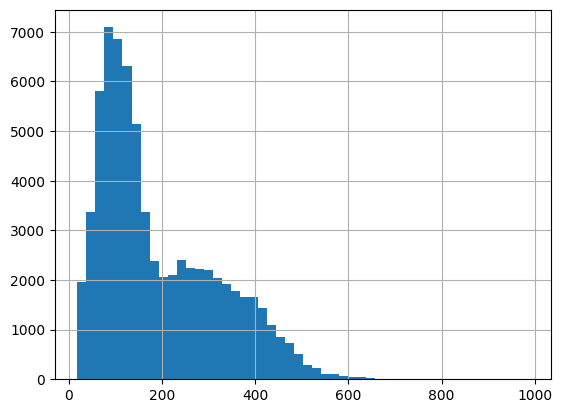

In [75]:
mod_train_df.num_sold.hist(bins=50)

(<AxesSubplot:>, <AxesSubplot:>)

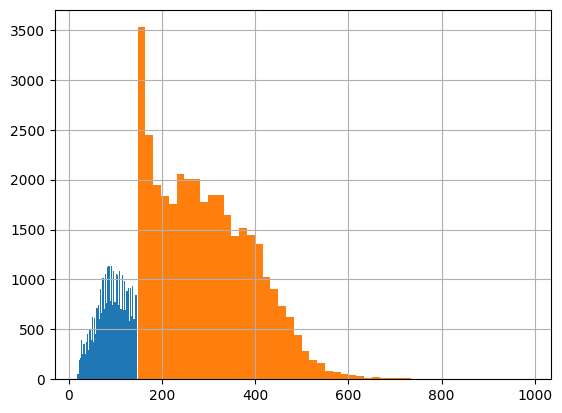

In [80]:
(
    mod_train_df.loc[mod_train_df.num_sold < 148, ]['num_sold'].hist(bins=50),
    mod_train_df.loc[mod_train_df.num_sold >= 148, ]['num_sold'].hist(bins=50)
)

(<AxesSubplot:>, <AxesSubplot:>)

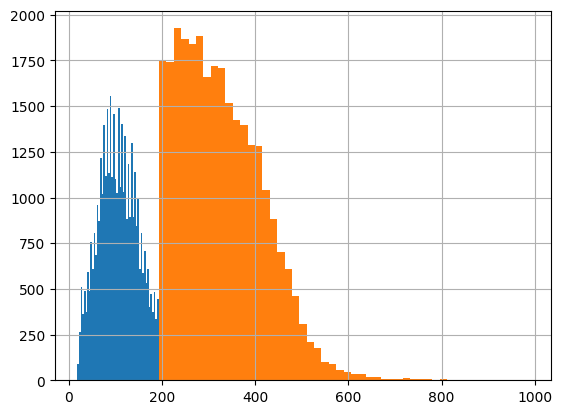

In [85]:
(
    mod_train_df.loc[mod_train_df.num_sold < 194, ]['num_sold'].hist(bins=50),
    mod_train_df.loc[mod_train_df.num_sold >= 194, ]['num_sold'].hist(bins=50)
)

## Product vs Store

There's no relationship between product and store regarding sales. KaggleMart has much larger sales no matter the book product as seen when just looking at sales to store.

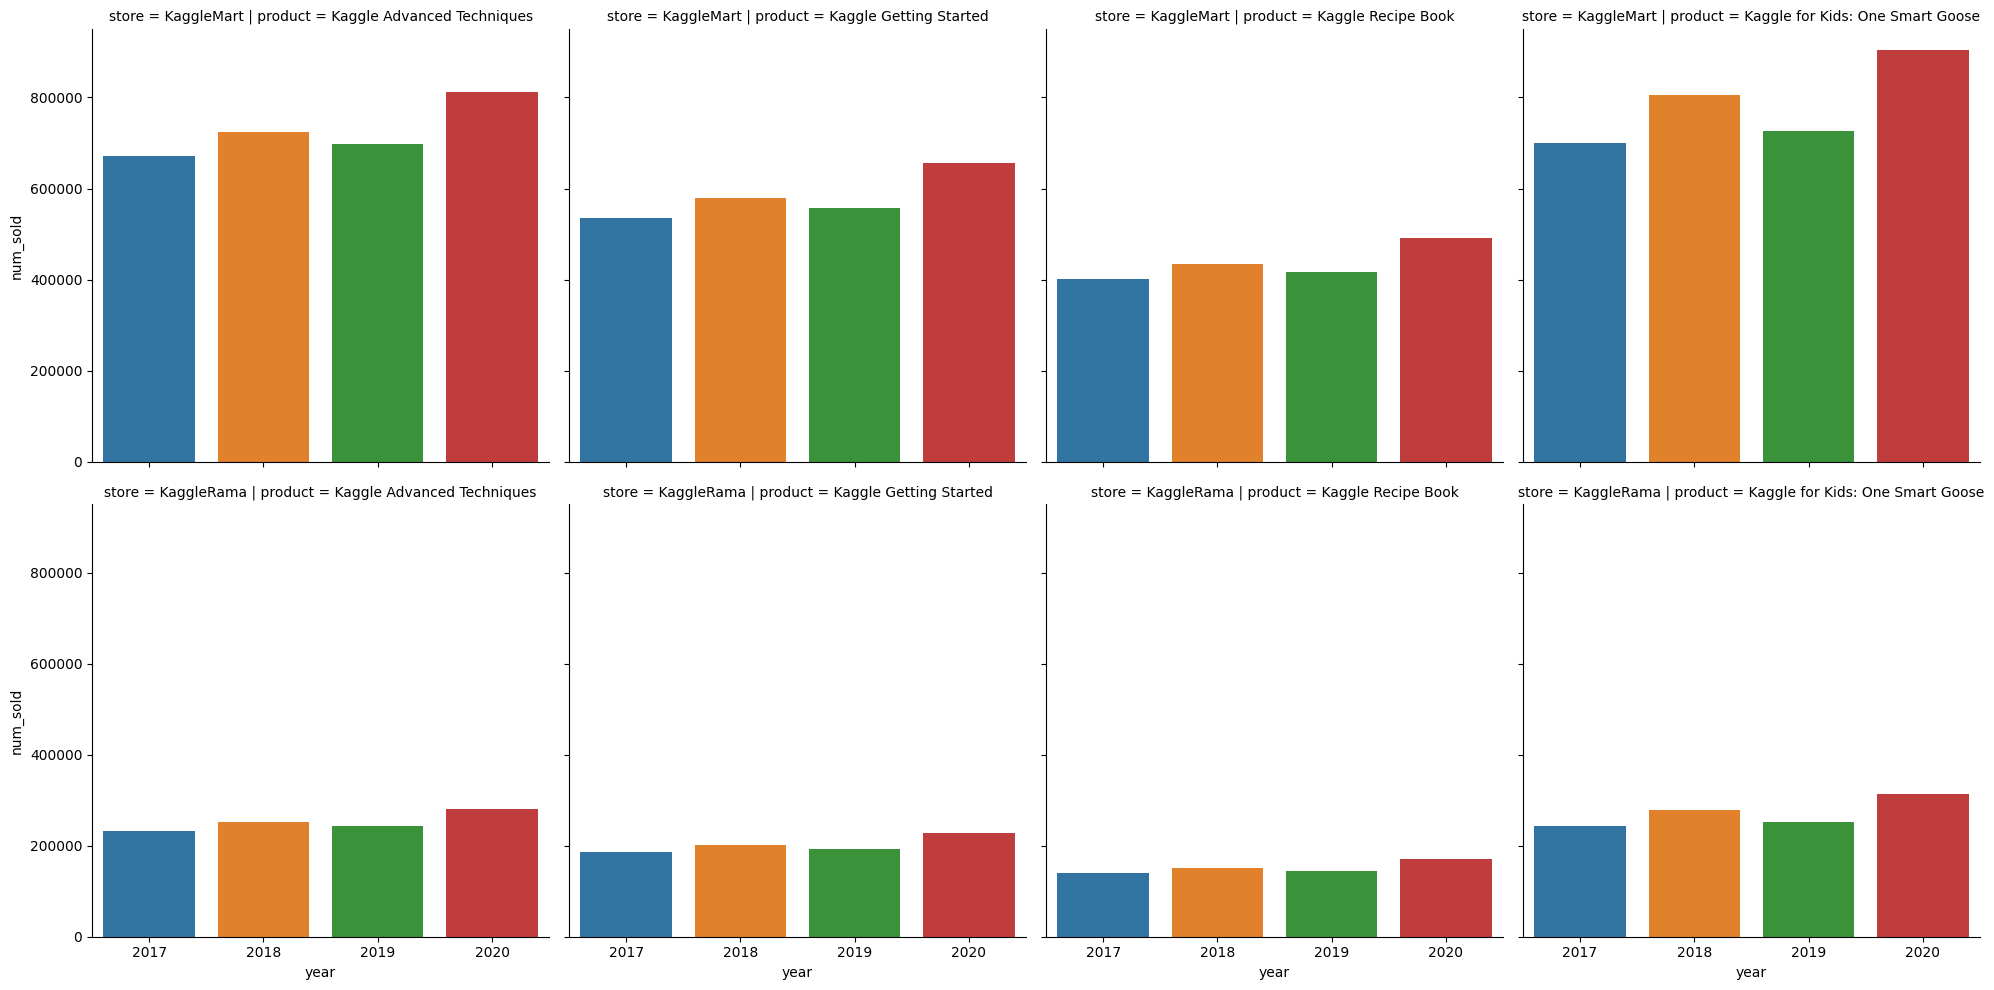

In [88]:
sns.catplot(
    x='year', y='num_sold',
    col='product', row='store',
    kind='bar', data=mod_train_df.groupby(['year', 'product', 'store']).agg('sum')['num_sold'].reset_index()
)

## Product vs Country

There's no relationship between product and country. You see the same expected behaviour when looking at across the row or column as when looking at each feature independently.

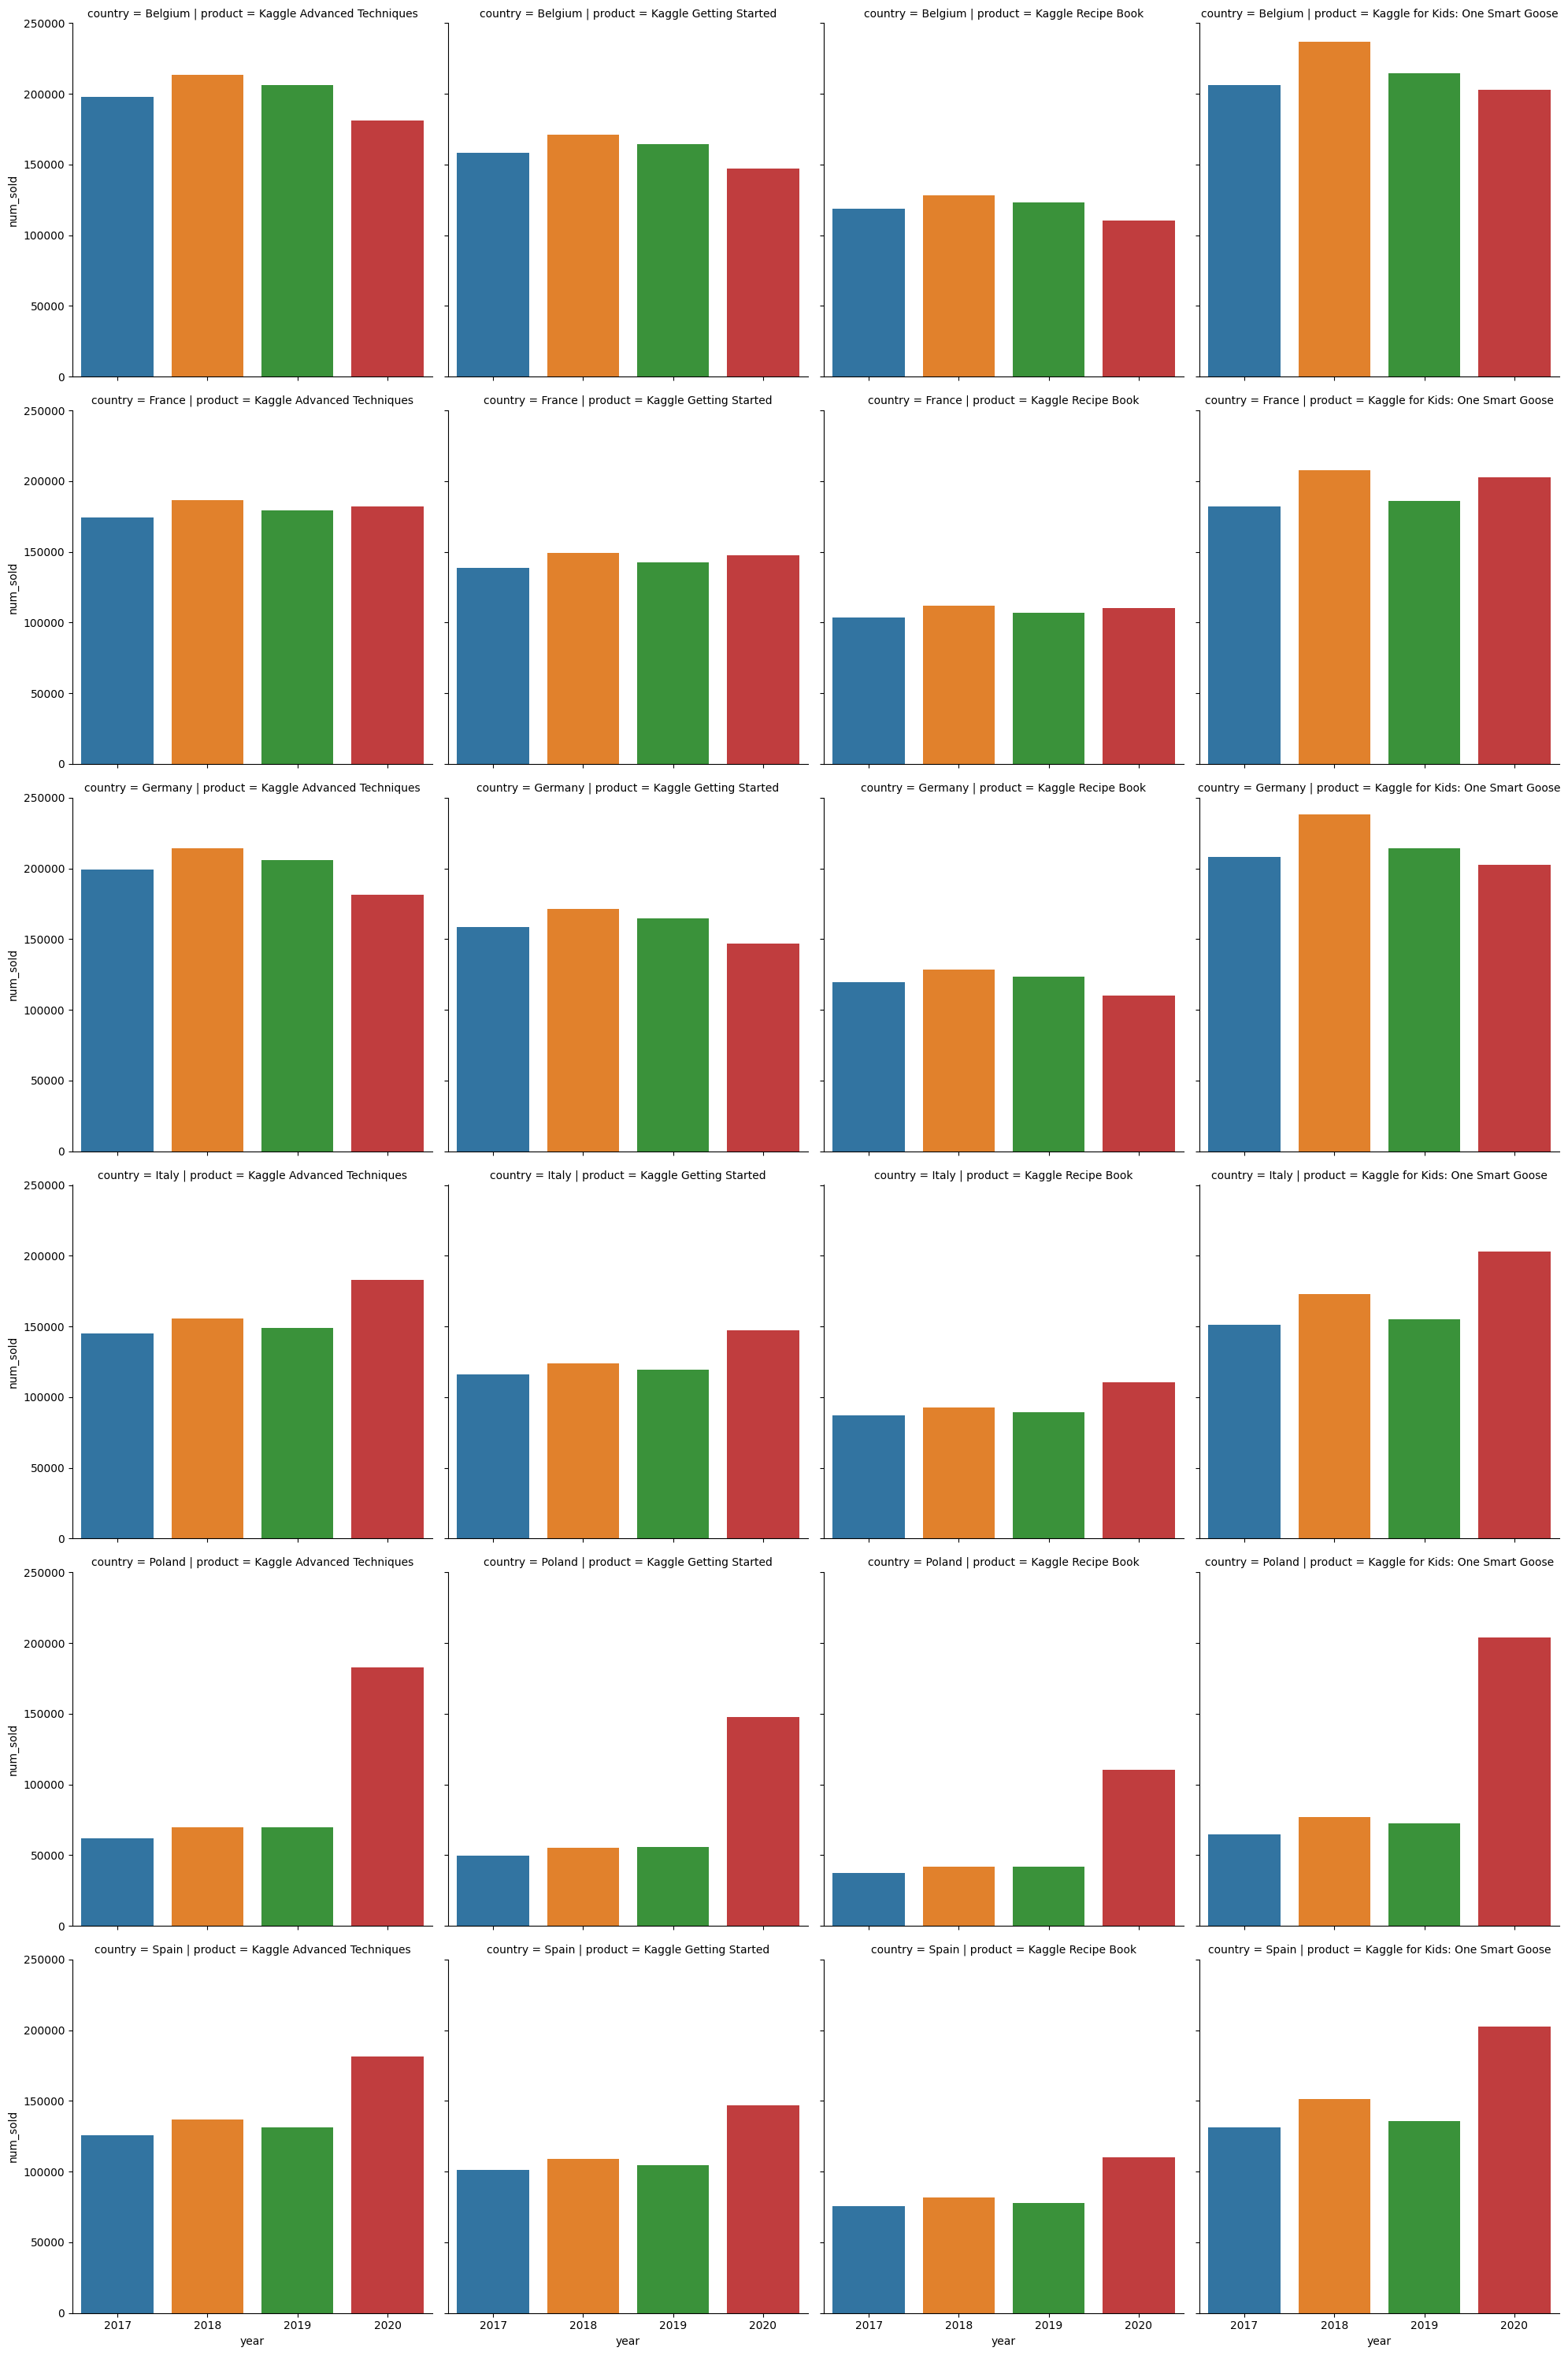

In [89]:
sns.catplot(
    x='year', y='num_sold',
    col='product', row='country',
    kind='bar', data=mod_train_df.groupby(['year', 'product', 'country']).agg('sum')['num_sold'].reset_index()
)

## Country vs Store

Similarly, there's no relationship between country and store.

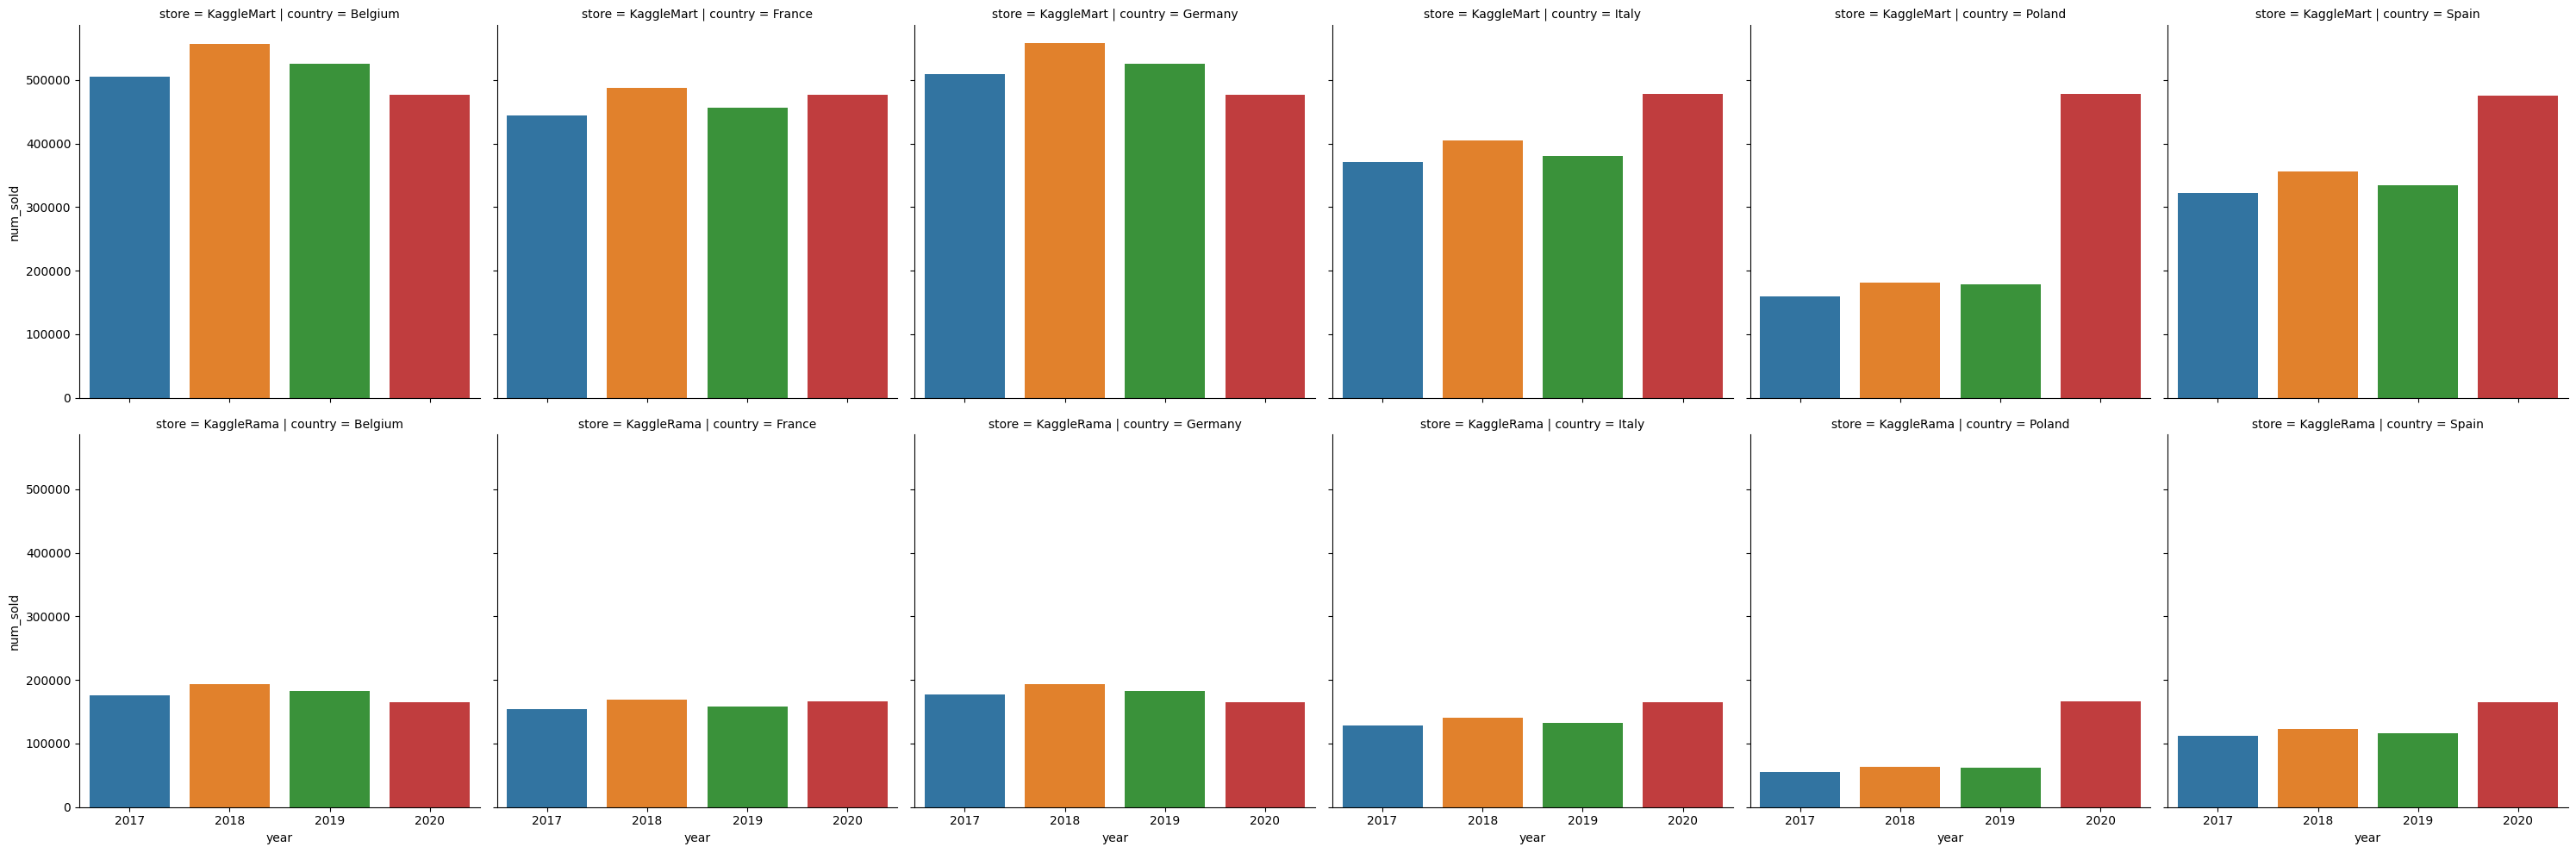

In [90]:
sns.catplot(
    x='year', y='num_sold',
    col='country', row='store',
    kind='bar', data=mod_train_df.groupby(['year', 'country', 'store']).agg('sum')['num_sold'].reset_index()
)